In [2]:
import sys
sys.path.append('./siamess')
from fastbook import *
from torchvision import transforms
from load_data import *
from models import *

In [9]:
p = untar_data(URLs.MNIST)

In [3]:
path = Path('./omniglot')

In [4]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('images_evaluation'),Path('images_background')]

In [6]:
train_ds, valid_ds = calc_dss(path, get_image_files, get_x_omniglot, get_y_omniglot, is_validation_omniglot)
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=128).cuda()

32455 files loaded.
19275 training samples / 13180 validation samples
mean: 0.9213306903839111 std: 0.2692219316959381 (on train)


In [57]:
dl_minist = DataLoader(mnist_ds, bs=128, device=torch.device('cuda'))

NameError: name 'mnist_ds' is not defined

tensor(0., device='cuda:0')


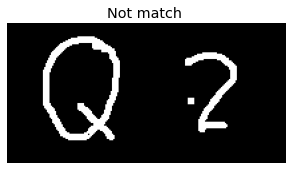

In [12]:
b = dls.one_batch() if True else dl_minist.one_batch()
idx=random.randint(0,63)
print(b[2][idx])
show_siamese(b[0][idx], b[1][idx], b[2][idx], cmap='binary', figsize=(5,5))

In [7]:
class SiameseDatasetAllPairs(torch.utils.data.Dataset):
    """ Generic dataset for siamese image match problem """
    def __init__(self, fns, get_x, get_y, tsfm):
        self.fns, self.get_x, self.tsfm = fns, get_x, tsfm
        self.cls = [ get_y(f) for f in fns ]

    def __getitem__(self, i):
        idx1     = i//len(self.fns)
        idx2    = i%len(self.fns)
        is_match = self.cls[idx1]==self.cls[idx2]
        t1 = self.tsfm( self.get_x( self.fns[idx1] ) )
        t2 = self.tsfm( self.get_x( self.fns[idx2] ) )
        return ( t1, t2, torch.Tensor([is_match]).squeeze() )

    def __len__(self): return len(self.fns)*len(self.fns)

In [8]:
valid_fns = list(filter(is_validation_omniglot,get_image_files(path)))
all_pairs_ds = SiameseDatasetAllPairs(valid_fns, get_x_omniglot, get_y_omniglot, transforms.Normalize(0.9248,0.2637))

In [9]:
all_pairs_dls = DataLoader(all_pairs_ds, bs=256)

In [ ]:
all_pairs_dls.one_batch()

In [16]:
test_model(SiameseModelNN(resnet18).cuda(), dls)

t1.shape = torch.Size([64, 1, 105, 105]) t2.shape = torch.Size([64, 1, 105, 105])
target.shape = torch.Size([64])
out.shape = torch.Size([64])


In [7]:
test_model(SiameseModelWithDistance(resnet34, F.pairwise_distance).cuda(), dls)

t1.shape = torch.Size([128, 1, 105, 105]) t2.shape = torch.Size([128, 1, 105, 105])
target.shape = torch.Size([128])
out.shape = torch.Size([128])


In [25]:
def my_loss_func_trivial(dists, target):
    return torch.where(target.bool(), dists, -dists).sum()

In [9]:
def my_loss_func_LeCun(dist, target, margin=2):
    neg_dist = torch.clamp(margin - dist, min=0.0)
    return 0.5 * torch.where(target.bool(), dist, -neg_dist).pow(2).mean()

In [16]:
learn = Learner(dls, SiameseModelNN(resnet18).cuda(), 
                loss_func = nn.BCEWithLogitsLoss(),  
                metrics = accuracy_multi, 
                splitter = siamese_splitter)

NameError: name 'SiameseModelNN' is not defined

In [10]:
def accuracy_dist(inp, targ, thresh=1):
    inp,targ = flatten_check(inp,targ)
    return ((inp<thresh)==targ.bool()).float().mean()

def similarity_with_cos(x,y): return sigmoid_range(F.cosine_similarity(x,y),0,2)
    
#distance_function = F.pairwise_distance
distance_function = nn.PairwiseDistance(p=1)
#def distance_function(x,y): return 
learn = Learner(dls, SiameseModelWithDistance(resnet18, distance_function).cuda(),
                loss_func = functools.partial(my_loss_func_LeCun,margin=2), 
                metrics = accuracy_dist)

In [30]:
Learner.lr_find??

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0003981071640737355)

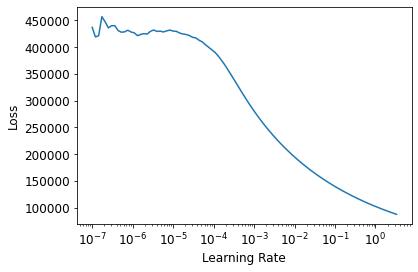

In [11]:
learn.freeze()
learn.lr_find()

In [12]:
learn.fit_one_cycle(3,0.33)

epoch,train_loss,valid_loss,accuracy_dist,time
0,28.803827,0.424331,0.662671,02:20
1,0.333189,0.275539,0.842033,02:09
2,0.198575,0.226176,0.887671,02:09


In [25]:
preds,targs = learn.get_preds()

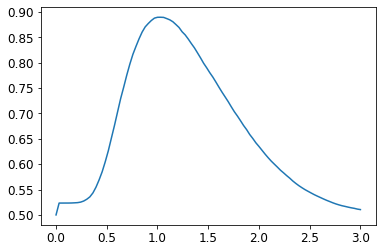

In [27]:
def thresh_finder(preds, targs, acc, x0, xf):
    xs = torch.linspace(x0,xf)
    accs = [ acc(preds, targs, thresh=x) for x in xs ]
    plt.plot(xs,accs)
thresh_finder(preds, targs, accuracy_dist, 0,3)

In [28]:
accuracy_dist(preds, targs, thresh=1)

TensorImageBW(0.8896)

In [94]:
m,s = 0.9213306903839111, 0.2692219316959381
databl = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=FuncSplitter(is_validation_omniglot),
    get_y=get_y_omniglot,
    batch_tfms=[Normalize.from_stats(m,s)])
dlsclassic = databl.dataloaders(path)

In [96]:
with torch.no_grad():
    features_list = []
    y_list = []
    for x,y in dlsclassic.train:
        features = learn.model.encoder(x)
        features = features.view(features.shape[0],-1)
        features_list.append(features)
        y_list.append(y)
    features_final = torch.cat(features_list)
    y_final = torch.cat(y_list)
    print(features_final.shape)
    print(y_final.shape)
    
    

torch.Size([13120, 8192])
torch.Size([13120])


In [98]:
f_pca = features_final.pca(2)
a,b = f_pca.t()

In [106]:
a,b,y_final = a.cpu(),b.cpu(),y_final.cpu()

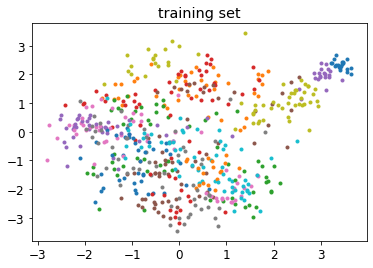

In [115]:
plt.title('training set')
for i in range(30):
    plt.plot(a[y_final==i], b[y_final==i], '.', label=f'class {i}')
plt.show() 

In [102]:
plt.title('training set')
plt.plot(a[y==0], b[y==0], '.', label='class 1')
plt.plot(a[y==1], b[y==1], '.', label='class 2')
plt.legend()
plt.show()

No handles with labels found to put in legend.


ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

In [35]:
learn.model.encoder

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=9.12010818865383e-07)

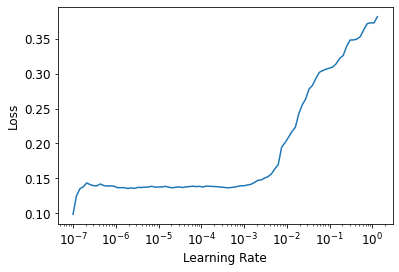

In [31]:
learn.unfreeze()
learn.lr_find()

In [32]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_dist,time
0,0.148262,0.195188,0.907436,02:11
1,0.144583,0.184155,0.913088,02:12
2,0.124540,0.172165,0.926024,02:12
3,0.112586,0.157992,0.928300,02:12
4,0.101305,0.149897,0.938316,02:12
5,0.092588,0.149160,0.937329,02:13
6,0.084435,0.142102,0.941009,02:14
7,0.078452,0.144059,0.939302,02:13
8,0.072268,0.139215,0.941085,02:17
9,0.071659,0.139331,0.940440,02:14


In [33]:
learn.export('omniglot_l1')

AttributeError: 'SiameseDataset' object has no attribute 'new_empty'

In [78]:
learn.save("omniglot_euclidean")

Path('models/omniglot_euclidean.pth')

In [19]:
learn.load("omniglot_bs128")

In [31]:
res = learn.validate()
res

(#2) [0.16149665415287018,0.9385432600975037]

In [21]:
learn.validate()

(#2) [0.15212112665176392,0.9476479291915894]

In [65]:
learn.get_preds(dl=dls.valid, with_loss=True)

(TensorImageBW([ -3.9081,   7.4506,  -9.4083,  ...,  -1.3797, -12.3450,   4.7503]),
 tensor([0., 1., 0.,  ..., 1., 0., 1.]),
 TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03]))

In [32]:
act,y=learn.get_preds(dl=dl_minist)
act = act.cuda()
y =y.cuda()
pred = act.sigmoid()>0.5
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [33]:
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [279]:
toacc = []
with torch.no_glearn.frad():
    for x1,x2,y in dl_minist:
        pred = learn.model(x1.cuda(),x2.cuda()).sigmoid()>0.5
        toacc.append(pred==y)
torch.cat(toacc).float().mean()
        

TensorImageBW(0.5000, device='cuda:0')

In [278]:
(pred==y).float().mean()

TensorImageBW(0.5000, device='cuda:0')

In [54]:
act, y = learn.get_preds(dl=dls.valid)
act = act.cuda()
y = y.cuda()

In [59]:
((act.sigmoid()>0.5) == y).float().mean()

TensorImageBW(0.9380, device='cuda:0')

In [46]:
y=torch.cat([b[2] for b in dls.valid])
y

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')

In [36]:
accuracy_multi??

In [239]:
len(train_ds)/100*7

2699.2000000000003

In [185]:
tact, ty, loss = learn.get_preds(dl=dls.valid, with_loss=True)
tids = torch.argsort(loss,descending=True)

In [194]:
tact = (tact.sigmoid()>0.5)

In [195]:
tact

TensorImageBW([False,  True, False,  ..., False, False,  True])

In [186]:
loss.shape

torch.Size([26360])

In [144]:
tdl = DataLoader(train_ds,bs=256,shuffle=False, device=torch.device('cuda'))
tact, ty, loss = learn.get_preds(dl=tdl, with_loss=True)
tids = torch.argsort(loss,descending=True)


TensorImageBW([3.3373e-04, 1.4312e-02, 3.9934e-05,  ..., 6.9412e-02, 1.8516e-02, 4.2128e-02])

In [138]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [118]:
tids = torch.argsort(loss,descending=True)
tids

TensorImageBW([37547, 31867, 12085,  ..., 32662, 32672,   930])

In [188]:
loss

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03])

In [189]:
l

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03], device='cuda:0')

In [130]:
xx=[train_ds[0],train_ds[1]]

In [179]:
tmp_dl = DataLoader(valid_ds,bs=256,shuffle=False)
loss_no_reduction=nn.BCEWithLogitsLoss(reduction='none')
l = []
with torch.no_grad():
    for x1,x2,y in tmp_dl:
        prob = learn.model(x1.cuda(),x2.cuda())
        loss = loss_no_reduction(prob,y.cuda())
        l.append(loss)
len(l)

103

In [180]:
l=torch.cat(l)

In [135]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [148]:
ids = torch.argsort(l,descending=True)tact

TypeError: argsort() received an invalid combination of arguments - got (list, descending=bool), but expected one of:
 * (Tensor input, name dim, bool descending)
 * (Tensor input, int dim, bool descending)


In [63]:
ids

TensorImageBW([37547, 12107, 26026,  ..., 38372, 38386, 38460], device='cuda:0')

In [163]:
v,i=interp.top_losses(100)
i

TensorImageBW([ 4111,  4087,  4097, 10151, 23107, 15555, 10133, 10157, 15531,  4563, 23081,  4599,  6043, 23109, 15527, 17373, 13061,  4891, 15415,  2381, 19063, 16011,  9505,  4561,  2615, 24361, 15899,
        24381, 15377, 16211,  4423,  9489, 15485,  4195,  8547,   465, 10617, 15135,  7531, 13077, 15433, 21837,  9882,   633, 15633, 24485, 15251, 15133,  2203, 24491,  5501, 15249, 15131, 12097,
        15505, 15159,  9756, 11027,  4449,  9093, 15947,  8197, 24505, 16089, 16109, 23218, 22115,  2233, 24489, 12274,  4197, 15277,  4333,  3882,  4191, 25047, 15551, 13959,  5475, 11015, 16019,
        15411,  5281, 15915,   418, 13244, 10740, 19148,  2213, 26060, 16229, 19196, 19128,  9484,  5461,  3614, 21443,  4994,  5106, 21665])

In [92]:
w1 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
w2 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
widgets.VBox([w1,w2])

In [116]:
def img_w(fn):
    w = widgets.Image(value=open(fn,'rb').read(),
                      format='png',
                      width=100,
                      height=100)
    return w
def imgs_wg(fns): return widgets.Box([ img_w(fn) for fn in fns])
    

In [117]:
fns = [path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png',
       path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png']
imgs_wg(fns)


Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00i\x00\x00\x00i\x01\x00\x00\x00\x00\…

In [90]:
w1.value, w2.value

(False, True)

In [158]:
'asdasd-asdasd'.split('-')

['asdasd', 'asdasd']

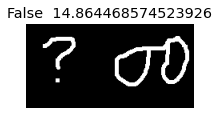

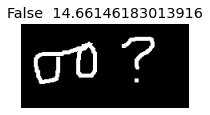

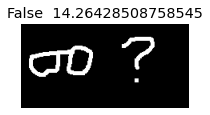

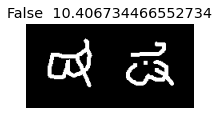

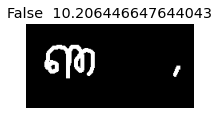

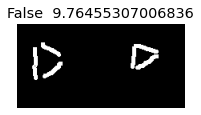

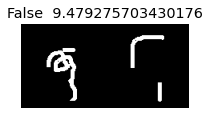

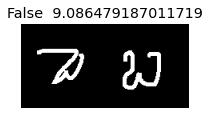

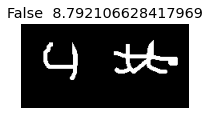

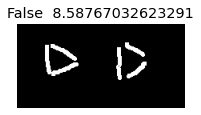

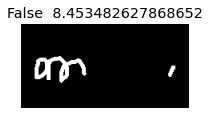

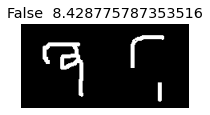

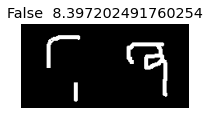

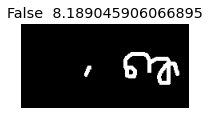

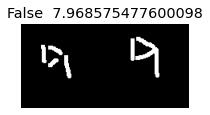

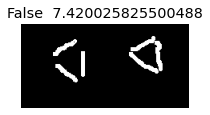

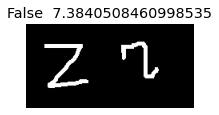

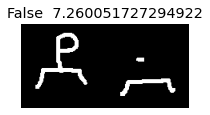

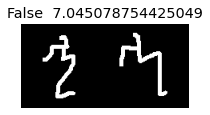

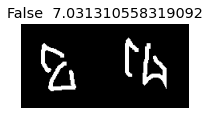

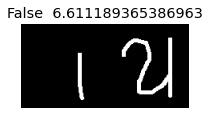

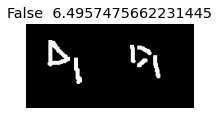

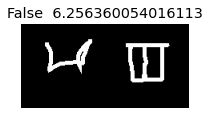

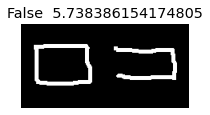

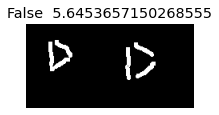

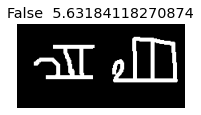

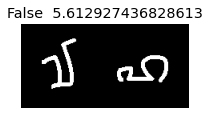

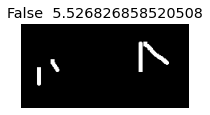

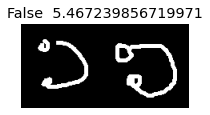

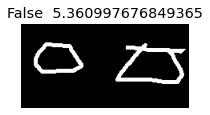

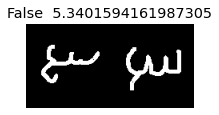

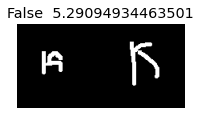

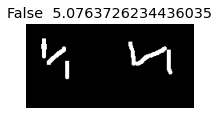

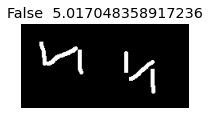

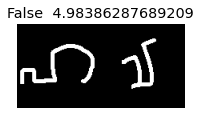

In [229]:
n = 50
d = defaultdict(lambda : defaultdict(list))
for idx in range(n):
    i = tids[idx]
    match = valid_ds[i][2]
    clase = valid_ds.cls[i//2]
    caracter = clase.split('-')[-1]
    lenguaje = ''.join(clase.split('-')[:-1])
    im1 =valid_ds[i][0]
    im2 = valid_ds[i][1]
    if match:
        clase2 = valid_ds.cls[valid_ds.idx2[i]]
        clases =  clase+clase2
        prediccion = str(tact[i].item())
        mensaje = prediccion + '  ' + str(loss[i].item())
        show_image(torch.cat([im1,im2],dim=2), title = mensaje ,cmap='binary')

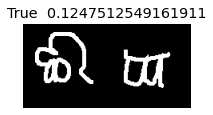

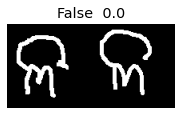

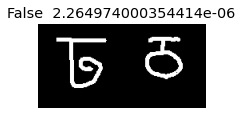

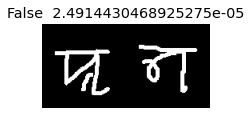

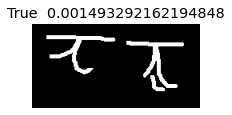

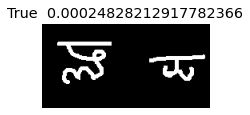

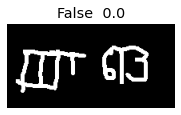

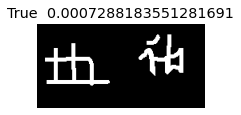

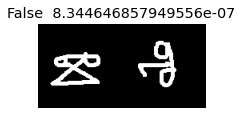

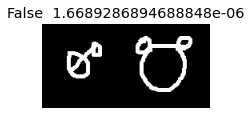

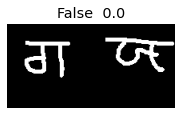

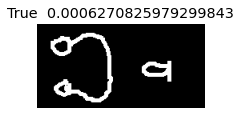

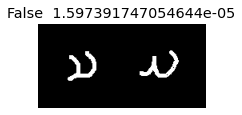

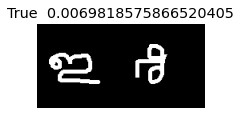

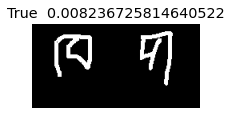

In [224]:
for lenguaje in d:
    for caracter in d[lenguaje]:
        for xx in d[lenguaje][caracter]:
            #lenguaje+'-'+caracter
            show_image(torch.cat(xx[0],dim=2), title = xx[1] ,cmap='binary')

/home/jupyter/tutorials/fastai/fastai/torch_core.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


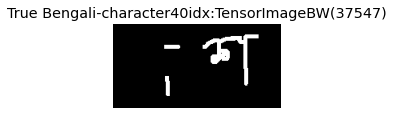

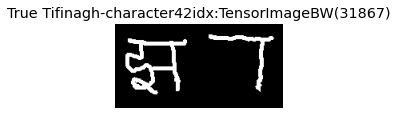

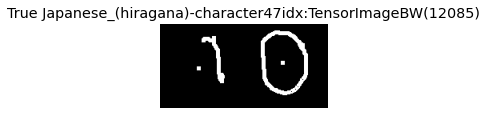

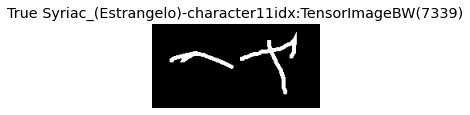

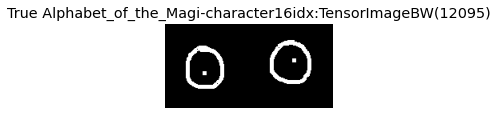

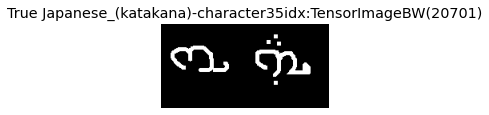

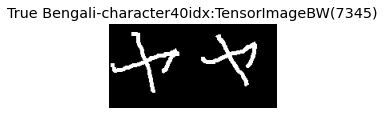

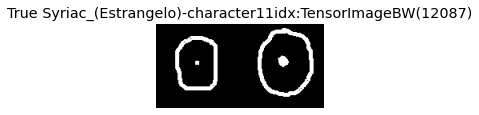

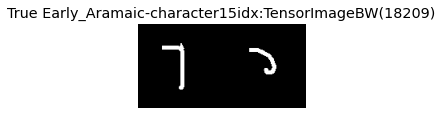

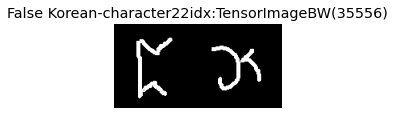

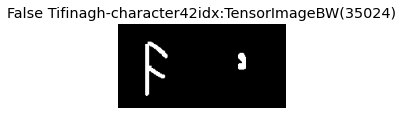

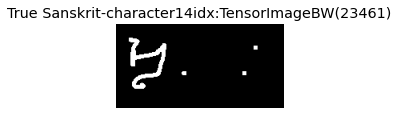

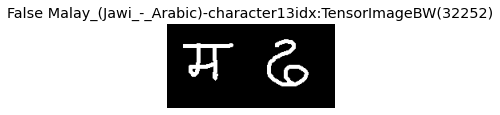

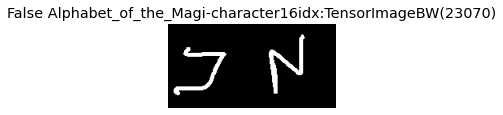

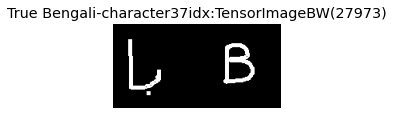

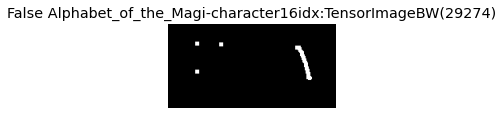

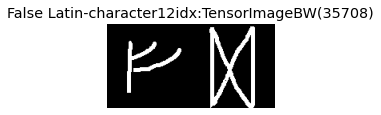

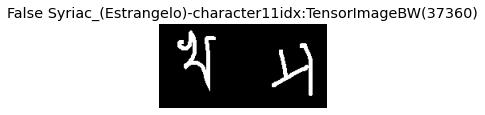

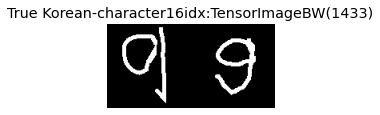

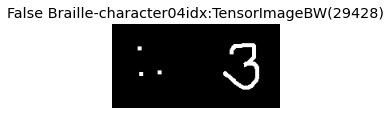

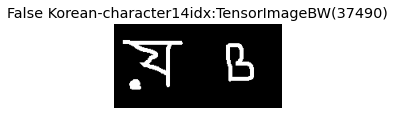

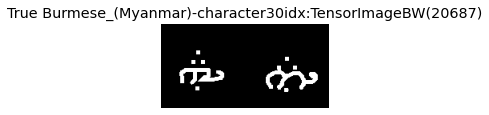

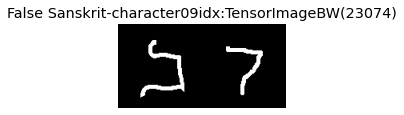

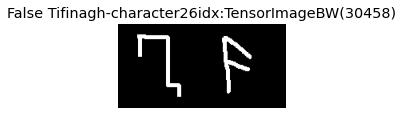

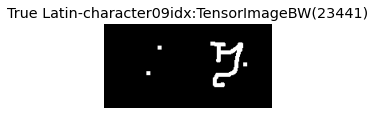

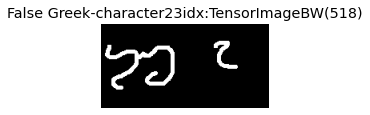

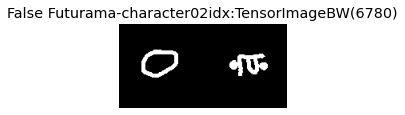

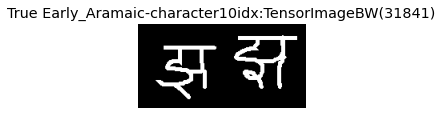

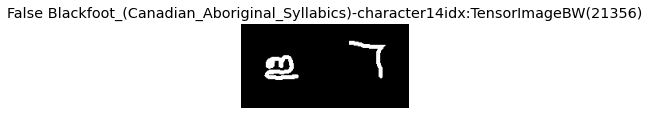

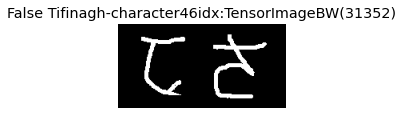

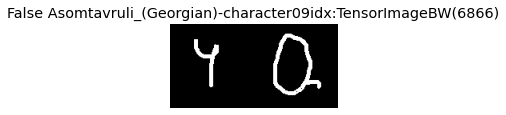

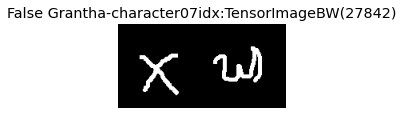

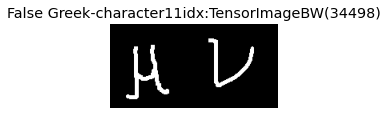

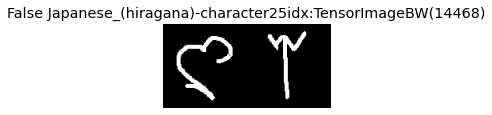

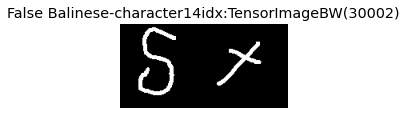

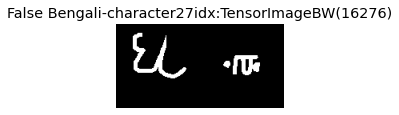

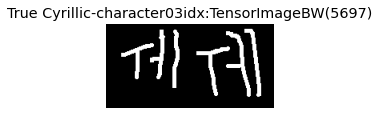

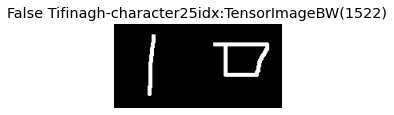

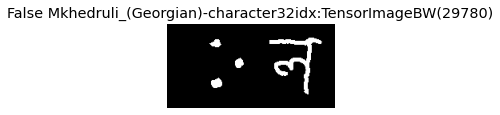

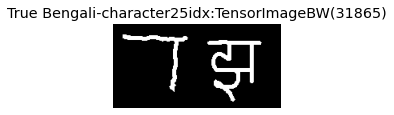

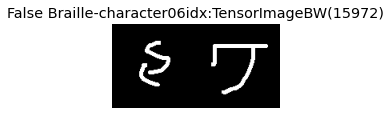

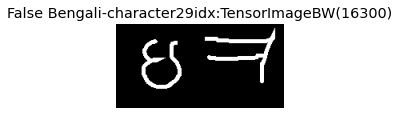

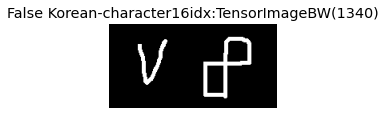

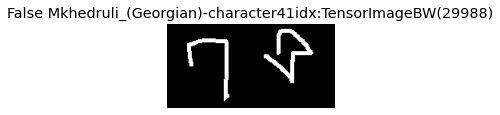

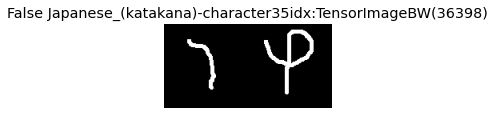

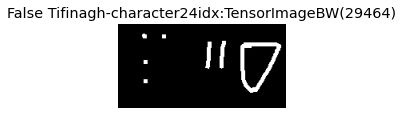

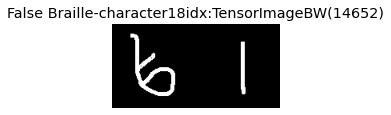

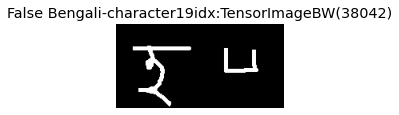

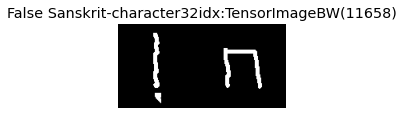

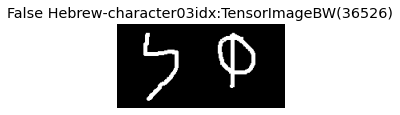

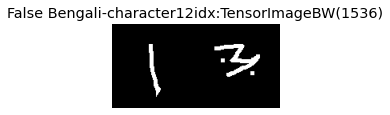

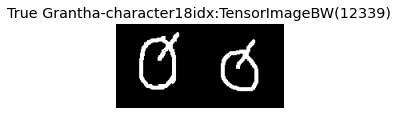

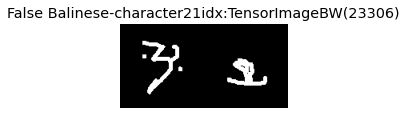

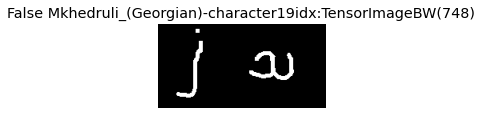

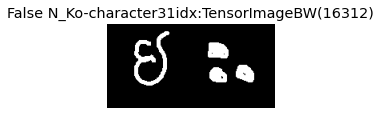

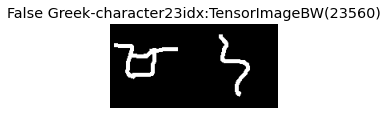

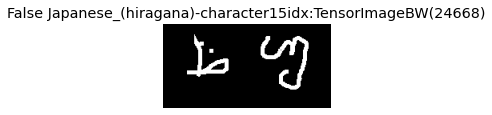

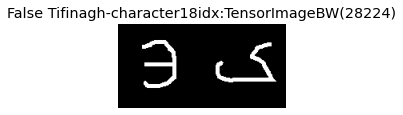

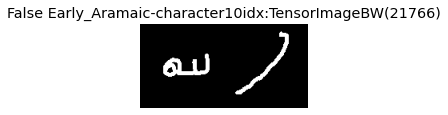

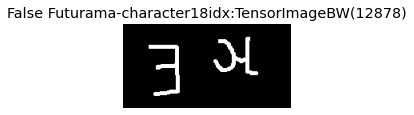

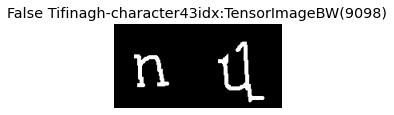

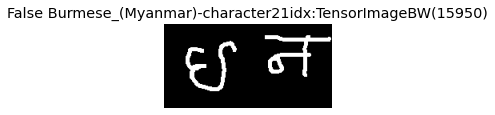

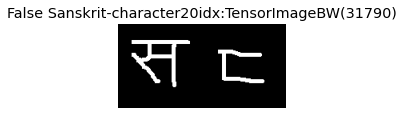

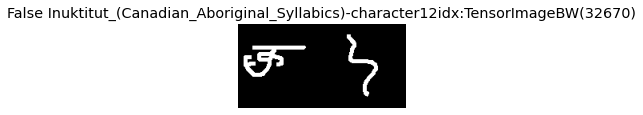

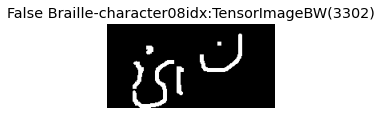

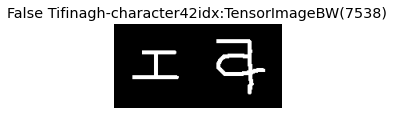

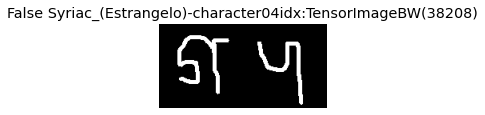

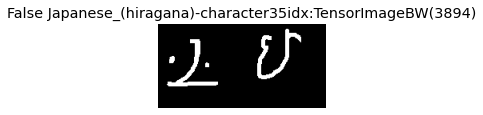

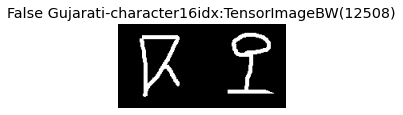

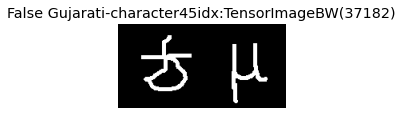

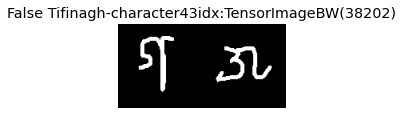

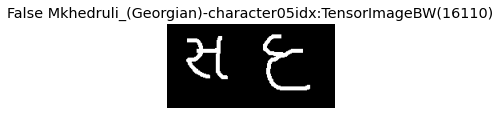

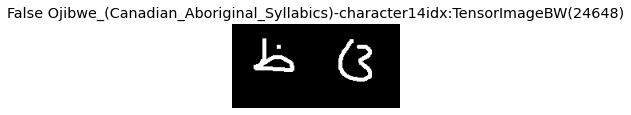

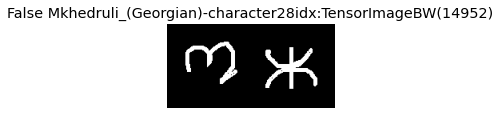

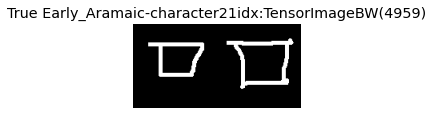

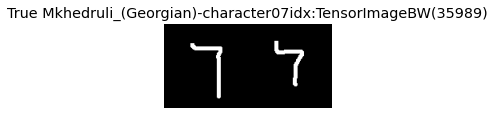

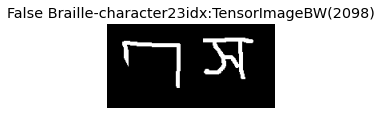

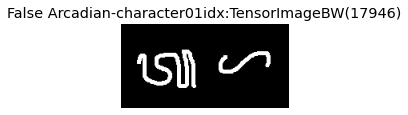

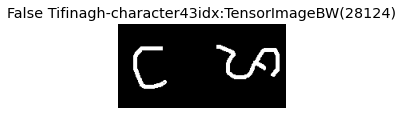

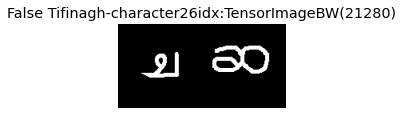

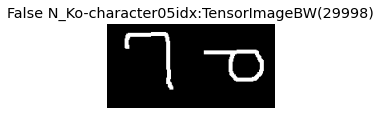

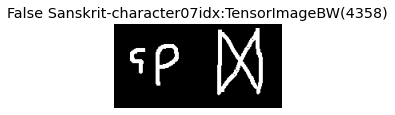

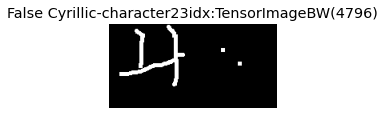

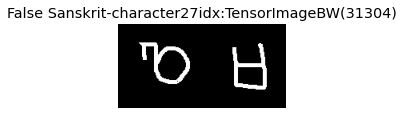

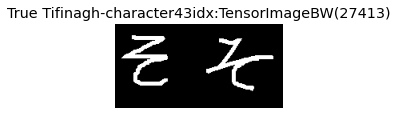

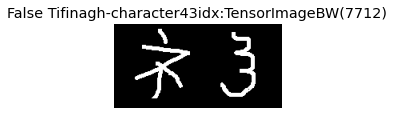

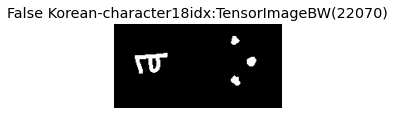

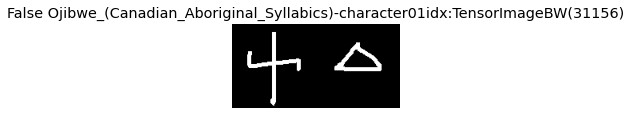

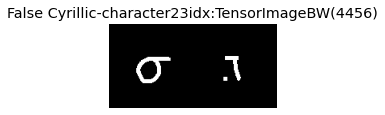

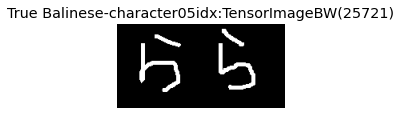

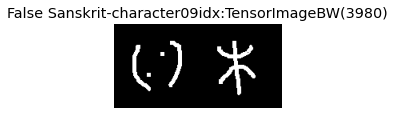

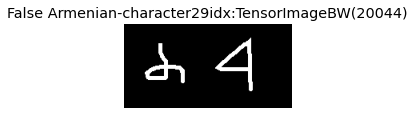

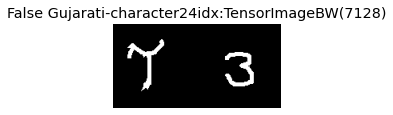

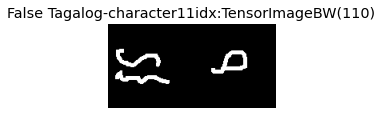

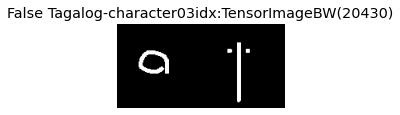

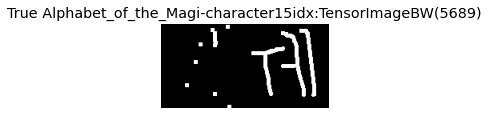

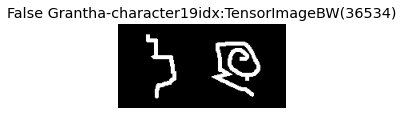

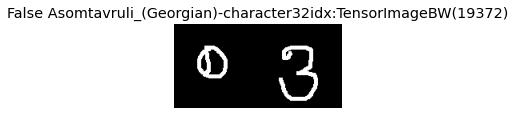

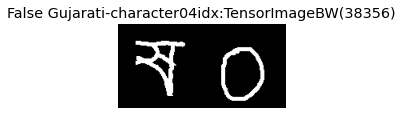

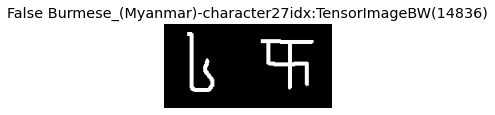

In [129]:
for idx in range(100):
    SiameseImage(train_ds[tids[idx]][0],train_ds[tids[idx]][1],train_ds[tids[idx]][2]).show(msg=train_ds.cls[ids[idx]//2]+'idx:'+str(tids[idx]),cmap='binary')

In [177]:
len(train_ds)

38560

In [151]:
valid_ds.cls[i[idx]//2]

'Ge_ez-character04'

<AxesSubplot:>

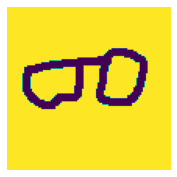

In [150]:
show_image( valid_ds.imgs[i[idx]//2] )

True


<AxesSubplot:>

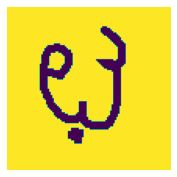

In [184]:
print(valid_ds.is_valid)
show_image(valid_ds.imgs[valid_ds.idx2[19148]])

<AxesSubplot:>

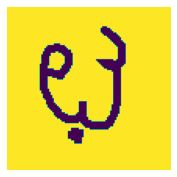

In [183]:
show_image(valid_ds[19148][1])

<AxesSubplot:>

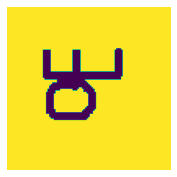

In [177]:
show_image(valid_ds.imgs[19148//2])